##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Multimodal Retrieval Augmented Generation (RAG)

This notebook is based on the technical session given at Google I/O 2024, [How to build Multimodal Retrieval-Augmented Generation (RAG) with Gemini](https://www.youtube.com/watch?v=LF7I6raAIL4). In this notebook, you will learn how to perform RAG with multimodal embeddings. Here are the key objectives of this notebook:

1. Extract text, images, and tables from a PDF document.
2. Generate embeddings for these different types of data.
3. Compare the embeddigs to each other to answer questions.

## What is retrieval augmented generation (RAG)?

Retrieval augmented generation (RAG), is a way to use external data or information to improve the accuracy of large language models (LLMs).

## What is the difference between text-based embeddings and multimodal embeddings?

Text-based embeddings involves producing embeddings just for text. Multimodal embeddings comprise embedding different types of data, including images, audio, and video. The advantages of multimodal embeddings include:

1. **Enhanced knowledge access**: Multimodal embeddings capture information about textual and visual information, which provides a comprehensive knowledge base for an LLM.
2. **Improved reasoning capabilities**: By including visual information, multimodal RAG allows you to make better inferences across different types of data modalities.  

## What is Gemini?

Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. Please visit this [link](https://ai.google.dev/gemini-api/docs?_gl=1*1f26jp*_up*MQ..&gclid=CjwKCAjwrcKxBhBMEiwAIVF8rM_p-nRNeJhgNmEE5c63Srn1lxH7whADCXmsaWKWYymrcur4c4w7jBoCGMgQAvD_BwE) for more information on Gemini.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Multimodal_RAG_with_Gemini.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

Install and import the Gemini API, the appropriate LangChain tools, as well as third party libraries. When installing these dependencies, the versions specified in the installations commands work with each other. For consistency, it is recommended to keep these version numbers for your own adaptations.

In [ ]:
!pip install -U -q google.generativeai # Install the Gemini API Python SDK
!pip install -U -q "unstructured[all-docs]"==0.12.6 # Unstructured library for parsing PDF upload
!pip install -U -q pypdf Pillow pydantic lxml pillow matplotlib opencv-python tiktoken # Install third party libraries

# Dependencies required by Unstructured PDF loader
!pip install --upgrade huggingface_hub # To extract images in hi-res
!sudo apt -y -qq install tesseract-ocr libtesseract-dev
!sudo apt-get -y -qq install poppler-utils
!pip install --user --quiet pytesseract==0.3.10 pdfminer.six==20221105

## Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Import the libraries

In [ ]:
import google.generativeai as genai

import os
import PIL
import textwrap
import numpy as np
import pandas as pd
from pprint import pprint
from unstructured.partition.pdf import partition_pdf
from IPython.display import display, Image, Markdown

## Download the data

In [ ]:
# Download documents and images used in this notebook
!gsutil cp gs://generativeai-downloads/data/med_gemini.pdf .
print("Download completed.")

Copying gs://generativeai-downloads/data/med_gemini.pdf...
/ [1 files][  6.5 MiB/  6.5 MiB]                                                
Operation completed over 1 objects/6.5 MiB.                                      
Download completed.


## Preprocessing

### Extract data from PDF

You will use the `unstructured` library to extract images, tables, and chunk text from our sample PDF file. Although it's a shorter document, the sample document still contains text along with images such as tables, charts, and graphs.

Please note that the images will be deposited in a separate directory called `figures/`. Specifically, the path in this notebook will be `/content/figures/`. You will be able to find all the images extracted in there. Please also note that capturing those images will cause the runtime of the cell below to be longer, and you must set `extract_images_in_pdf` to `True` and the `strategy` parameter must be `hi_res` in order to extract the images. For more information on extracting images from PDFs using the `unstructured` library, please check the [`partition_pdf` documentation](https://docs.unstructured.io/open-source/core-functionality/partitioning#partition-pdf).

In [ ]:
pdf_file_path = '/content/med_gemini.pdf'

# Extract images, tables, and chunk text from the PDF file provided.
try:
  raw_pdf_elements = partition_pdf(
      filename=pdf_file_path,
      extract_images_in_pdf=True,
      infer_table_structure=True,
      chunking_strategy="by_title",
      max_characters=1000,
      combine_text_under_n_chars=250,
      strategy="hi_res",
  )
except PIL.UnidentifiedImageError:
  print("Could not identify image file.")

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
len(raw_pdf_elements)

333

In [ ]:
raw_pdf_elements[51].text # Display sample text extracted

'3. Uncertainty-guided search query generation: Given conflicting responses from step (1), we prompt Med-Gemini-L 1.0 to generate three search queries whose results would help resolve the conflict. Our motivation of conditioning on previously generated but conflicting responses is to retrieve search results that are directly targeted at resolving the model’s uncertainty to the question.\n\n4. Search retrieval: The generated queries are then submitted to a web search engine, and the retrieved results are incorporated into Med-Gemini-L 1.0’s input prompt for the next iteration, starting back at step (1). Augmenting the prompt with search results enables the model to refine its response by considering external relevant insights obtained from web search.'

In [ ]:
tables, texts = [], []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

In [ ]:
tables[0] # Display a sample of the table extracted

'Task Dataset OOD Metric Med-Gemini-L 1.0 SoTA SoTA method Reference Close-ended QA Open-ended QA MedQA NEJM CPC GeneTuring GeneTuring GeneTuring GeneTuring GeneTuring GeneTuring GeneTuring GeneTuring GeneTuring GeneTuring Human genome DNA alignment GeneTuring GeneTuring Gene name extraction Gene alias Gene name conversion Gene location SNP location Gene SNP association Protein-coding genes Gene disease association Gene ontology TF regulation ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ ✓ Accuracy Top-1 accuracy Top-10 accuracy Accuracy Accuracy Accuracy Accuracy Accuracy Accuracy Accuracy Accuracy Accuracy Accuracy Accuracy Accuracy 91.1 30.7 72.3 86.0 72.7 100.0 83.0 0.0 0.0 100.0 82.1 52.3 65.3 0.0 12.5 90.2 29.2 59.1 85.0 66.0 85.0 61.0 5.00 0.0 97.0 84.0 42.0 62.0 7.0 20.0 GPT-4 with MedPrompt AMIE AMIE GPT-4 GPT-4 GPT-4 GPT-4 ChatGPT GPT-4 GPT-4 GPT-4 GPT-4 GPT-4 BioGPT GPT-3 Nori et al. (2023) McDuff et al. (2023) McDuff et al. (2023) Hou and Ji (2023) Hou and Ji (2023) Hou and Ji (2023) Hou and Ji'

## Configure your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see  [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

## Generate text and table summaries

You will use `gemini-1.5-flash` to generate summaries of text for the tabular and text data. Use the prompt below to generate the summaries of the inputs.

In [ ]:
MODEL_NAME = "models/gemini-1.5-flash"
model = genai.GenerativeModel(model_name=MODEL_NAME) # Set the model to Gemini 1.5 Flash

def make_prompt(element):
  return f"""You are an agent tasked with summarizing research tables and texts from research papers for retrieval. \
             These summaries will be embedded and used to retrieve the raw text or table elements. \
             Give a concise summary of the tables or text that is well optimized for retrieval. Table or text: {element} """

def generate_text_summary(data):
  if len(data) >= 0:
    prompt = make_prompt(data)
    response = model.generate_content(prompt)
    return response

In [ ]:
# Generate summaries for text elements
text_summaries = [generate_text_summary(text) for text in texts]

# Generate summaries for table elements
table_summaries = [generate_text_summary(table) for table in tables]

Take a look at the original text compared to the summarized text:

In [ ]:
pprint(f"Original text: {texts[51]}")
pprint("-"*100)
pprint(f"Summarized text: {text_summaries[51].text}")

('Original text: 3. Uncertainty-guided search query generation: Given '
 'conflicting responses from step (1), we prompt Med-Gemini-L 1.0 to generate '
 'three search queries whose results would help resolve the conflict. Our '
 'motivation of conditioning on previously generated but conflicting responses '
 'is to retrieve search results that are directly targeted at resolving the '
 'model’s uncertainty to the question.\n'
 '\n'
 '4. Search retrieval: The generated queries are then submitted to a web '
 'search engine, and the retrieved results are incorporated into Med-Gemini-L '
 '1.0’s input prompt for the next iteration, starting back at step (1). '
 'Augmenting the prompt with search results enables the model to refine its '
 'response by considering external relevant insights obtained from web search.')
'----------------------------------------------------------------------------------------------------'
('Summarized text: This research uses a method called uncertainty-guided '

Take a look at the original table compared to the summarized table:

In [ ]:
pprint(f"Original table: {tables[3]}")
pprint("-"*100)
pprint(f"Summarized table: {table_summaries[3].text}")

('Original table: Task Close-ended VQA Close-ended VQA Close/open-ended VQA '
 'Close-ended Signal QA Open/Close-ended VQA Open/Close-ended VQA '
 'Classification Classification Dataset NEJM Image Challenge USMLE-MM MMMU-HM '
 'ECG-QA Slake-VQA Path-VQA PAD-UFES-20 6-class PAD-UFES-20 6-class Multimodal '
 'fine-tuned ✓ ✓ ✓ ✓ ✓ Metric Accuracy Accuracy Accuracy Accuracy Token F1 '
 'Token F1 Accuracy Accuracy Med-Gemini 69.7∗ 93.5∗ 67.3∗ 57.7‡ 87.5† 64.7† '
 '85.9† 78.8† SoTA 61.0 80.4 64.7 51.6 89.3 62.7 88.0 N/A SoTA method GPT-4V '
 'GPT-4V GPT-4V GPT-4 with SE-WRN Med-PaLM M Med-PaLM M Med-PaLM M N/A '
 'Reference Buckley et al. (2023) Reproduced Yue et al. (2023) Oh et al. '
 '(2023) Tu et al. (2024a) Tu et al. (2024a) Tu et al. (2024a) New Split')
'----------------------------------------------------------------------------------------------------'
('Summarized table: This table compares the performance of different models on '
 'various visual question answering (VQA) and signal

### Generate image summaries

In the code cell below, you will use a prompt to input an image and generate a text summary of that image. The `gemini-1.5-flash` model will be used to accomplish this as well.

Encoding an image is important to protect the image data while storing and retrieving it.

In [ ]:
def generate_image_summaries(image_paths):
  image_summaries = [] # Store image summaries

  prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval.
    If it's a table, extract all elements of the table.
    If it's a graph, explain the findings in the graph.
    Include details about color, proportion, and shape if necessary to describe the image. \
    Do not include any numbers that are not mentioned in the image.
    """

  for image_path in image_paths:
    img = PIL.Image.open(image_path.path)
    response = model.generate_content([prompt, img])
    image_summaries.append(response.text)

  return image_summaries

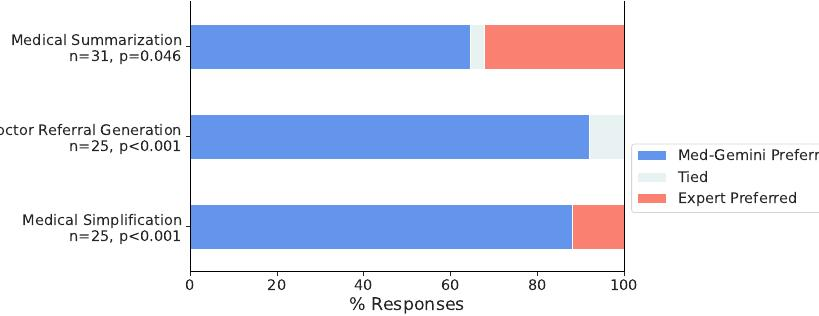

In [ ]:
# Take look at one of the images
img = PIL.Image.open(f"/content/figures/{os.listdir('/content/figures/')[1]}")
display(img)

In [ ]:
image_summaries = generate_image_summaries(os.scandir('/content/figures/'))

"A chest x-ray image showing the heart at the upper limits of normal size. The mediastinal and hilar contours appear within normal limits. The lungs appear clear. There are no pleural effusions or pneumothorax. Mild degenerative changes are noted along the lower thoracic spine. There is no evidence of acute disease.  Small osteophytes are present in the image, but along the lateral margins rather than anterior margins of the vertebral bodies.  The x-ray could potentially contribute to the patient's back pain, but correlation doesn't equal causation.  Minor wear and tear in the lower spine, common with age. No signs of infection or fluid buildup.  The expanded mediastinal and hilar contours are normal. The lungs are well cariomediastinal, without focal consolidation, pleural effusion or pneumothorax. Mild degenerative changes are seen in the thoracic spine. There is no acute cardiopulmonary pathology.  The patient has a history of back pain. This might explain the back pain."

In [ ]:
image_summaries[1]

'A horizontal bar chart showing the percentage of responses for three medical tasks. The tasks are Medical Simplification, Doctor Referral Generation, and Medical Summarization. The chart shows that Med-Gemini was preferred in most cases. The x-axis represents the percentage of responses and the y-axis represents the three tasks.  The chart is segmented into three colors, blue represents Med-Gemini Preferred, white represents tied, and orange represents Expert Preferred.'

## Embedding generation

Generate embeddings for the texts, tables, and images now. Store them in the Pandas dataframe for now.

### API changes to Embeddings with model embedding-001

For the new embeddings model, `embedding-001`, there is a new `task type` parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [ ]:
def create_embeddings(data):
  return genai.embed_content(model="models/embedding-001",
                             content=data,
                             task_type="retrieval_document")

In [ ]:
# Extract the text part of the GenerateContentResponse for each data summary
text_summaries = [summary.text for summary in text_summaries]
table_summaries = [summary.text for summary in table_summaries]

In [ ]:
# Generate embeddings for text summaries, and add to the dataframe.
data_df = pd.DataFrame(columns=['Original Text or Image', 'Summary', 'Embeddings']) # Create new Pandas dataframe
data_df['Original Text or Image'] = texts + tables + [img.path for img in os.scandir('/content/figures/')]
data_df['Summary'] = text_summaries + table_summaries + image_summaries
data_df = data_df[data_df['Original Text or Image'] != ''] # Drop empty entries
data_df['Embeddings'] = data_df['Original Text or Image'].apply(create_embeddings)
# Get the value of the 'embedding' key for each entry in data_df['Embeddings']
data_df['Embeddings'] = data_df['Embeddings'].apply(lambda x: x['embedding'])
data_df.head()

,Original Text or Image,Summary,Embeddings
0,4 2 0 2\n\ny a M 1 ] I A . s c [\n\n2 v 6 1 4 ...,This table presents information about Gemini m...,"[0.0017189111, -0.007278571, -0.016357312, 0.0..."
1,"Khaled Saab◦,1, Tao Tu◦,‡,1, Wei-Hung Weng◦,1,...",This is a list of authors from a research pape...,"[-0.014693135, -0.032797173, -0.08992019, -0.0..."
2,"Joelle Barral2, Greg Corrado1, Christopher Sem...",This table lists the authors of a research pap...,"[-0.007718093, -0.012944852, -0.01925978, 0.02..."
3,Excellence in a wide variety of medical applic...,## Med-Gemini: A Family of Multimodal Models f...,"[0.010133818, -0.044564407, -0.036059625, 0.01..."
4,best-performing Med-Gemini model achieves SoTA...,## Med-Gemini: A Powerful Medical Language Mod...,"[0.020373307, -0.019176448, -0.04262126, 0.018..."


## Embedding search with queries

In [ ]:
query1 = "What is self-training?"
query2 = "How does Med-Gemini-L's performance compare when it comes to self-training and without self-training?"
query3 = "How does the MedQA evaluation work?"
query4 = "What do the hypothetical multimodal medical dialogues demonstrate about Med-Gemini?"
query5 = "What are the motivations for applying LLMs to clinical problems?"
query6 = "What models are Med-Gemini benchmarked against?"

queries = [query1, query2, query3, query4, query5, query6]

Use the `find_best_passage` function to calculate the dot products, and then sort the dataframe from the largest to smallest dot product value to retrieve the relevant passage out of the database. Embed the queries as well so you can perform a search against the database of knowlege.

In [ ]:
def find_best_passage(query, dataframe):
  """
  Compute the distances between the query and each document in the dataframe
  using the dot product.
  """
  query_embedding = genai.embed_content(model="models/embedding-001",
                                        content=query,
                                        task_type="retrieval_query")
  dot_products = np.dot(np.stack(dataframe['Embeddings']), query_embedding["embedding"])
  idx = np.argmax(dot_products)
  return dataframe.iloc[idx]['Original Text or Image'] # Return text from index with max value

Here is an example of the retrieval.

In [ ]:
passage = find_best_passage(query1, data_df)
pprint(passage)

'2.1. Advanced reasoning via self-training and web search integration'


## Summarization

Now use `generate_content` once more to generate answers to the queries posed earlier.

In [ ]:
def make_prompt(query, relevant_passage):
  escaped = relevant_passage.replace("'", "").replace('"', "").replace("\n", " ")
  prompt = textwrap.dedent("""You are a helpful and informative bot that answers questions using text from the reference passage included below. \
  You are answering questions about a research paper. \
  Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. \
  However, you are talking to a non-technical audience, so be sure to break down complicated concepts and \
  strike a friendly and converstional tone. \
  If the passage is irrelevant to the answer, you may ignore it.
  QUESTION: '{query}'
  PASSAGE: '{relevant_passage}'

    ANSWER:
  """).format(query=query, relevant_passage=escaped)

  return prompt

In [ ]:
prompt = make_prompt(query1, passage)
pprint(prompt)

('You are a helpful and informative bot that answers questions using text from '
 'the reference passage included below.   You are answering questions about a '
 'research paper.   Be sure to respond in a complete sentence, being '
 'comprehensive, including all relevant background information.   However, you '
 'are talking to a non-technical audience, so be sure to break down '
 'complicated concepts and   strike a friendly and converstional tone.   If '
 'the passage is irrelevant to the answer, you may ignore it.\n'
 "  QUESTION: 'What is self-training?'\n"
 "  PASSAGE: '2.1. Advanced reasoning via self-training and web search "
 "integration'\n"
 '\n'
 '    ANSWER:\n')


In [ ]:
# For each query in the list, generate a list of passages
passages = [find_best_passage(query, data_df) for query in queries]

In [ ]:
prompts = [make_prompt(query, passage) for query, passage in zip(queries, passages)]

In [ ]:
# Generate Markdown of the response.text from `generate_content` when passing in the information
responses = [model.generate_content(prompt) for prompt in prompts]

for response, query in zip(responses, queries):
  display(Markdown(f"**{query}**")) # Make query bold in Markdown
  display(Markdown(response.text))

**What is self-training?**

The research paper mentions "self-training," but it doesn't provide a definition.  Therefore, I can't tell you what self-training is based on this passage. 


**How does Med-Gemini-L's performance compare when it comes to self-training and without self-training?**

The research paper does not provide information on how Med-Gemini-L performs with and without self-training.  It only explains the self-training process, which involves prompting the model to generate "chains of thought" (CoTs) based on expert demonstrations, filtering out erroneous predictions, fine-tuning the model on the generated CoTs, and repeating the process until the model's performance plateaus. 


**How does the MedQA evaluation work?**

The MedQA evaluation uses a method called "prediction accuracy," which means it checks how often the model gets the right answer to a question.  To make sure the evaluation is accurate, they ask real doctors to look at the questions and make sure there's no missing information or confusing wording. This way, the researchers can get a clearer picture of how well the model is performing. 


**What do the hypothetical multimodal medical dialogues demonstrate about Med-Gemini?**

The hypothetical multimodal medical dialogues show that Med-Gemini has potential for use in medical research, education, and even patient care. 


**What are the motivations for applying LLMs to clinical problems?**

The passage focuses on the challenges and opportunities associated with applying LLMs to clinical problems, not the motivations for doing so. Therefore, I can't answer your question using this passage. 


**What models are Med-Gemini benchmarked against?**

The research paper doesn't explicitly state which models Med-Gemini was benchmarked against, but it mentions that Med-Gemini was tested on 25 tasks across 14 medical benchmarks.  These benchmarks likely include tasks and datasets commonly used in the field of medical AI, but the specific models used for comparison aren't specified. 
